# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Sergio Villa Rodriguez

**Professor**: Pablo Camarillo Ramirez

# Introduction

Caliente TV is a streaming platform for sports. Especially football (soccer), and this company shares the transmission rights of the UEFA Champios League with HBO Max. This means that some matches are transmitted by Caliente TV and some others by HBO Max. And this platform is known for its instability and bad transmission quality.

This project analyzes data from the stream and will provide useful information for making a decision to get the user a better service.

# Dataset

The dataset used in this project is a generic dataset from a streaming application. It does not contain real information.

Link to dataset: https://www.kaggle.com/datasets/rajatkumar30/streaming-application-viewership 

## Find Spark

In [9]:
import findspark
findspark.init()

## Create SparkSession

In [10]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on data sources (Files)") \
    .master("spark://f0e377311925:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

## Define Schema

In [11]:
from sergiovillaa.spark_utils import SparkUtils

columns_schema = [('user_id', 'string'),
                  ('session_id', 'string'),
                  ('device_id', 'int'),
                  ('match_id', 'int'), # match/game/event id
                  ('duration_watched', 'double'), 
                  ('genre', 'string'), #irrelevant
                  ('country', 'string'), #irrelevant
                  ('age', 'int'), #irrelevant
                  ('gender', 'string'), #irrelevant
                  ('subscription_type', 'string')]

schema = SparkUtils.generate_schema(columns_schema)                  

## Load CSV

In [12]:
df = spark.read \
        .option("header", "true") \
        .schema(schema) \
        .csv("/opt/spark/work-dir/data/final_project/")

# Transformations and Actions

In [13]:
from pyspark.sql.functions import when, lit

# Eliminating columns that are not useful to simulate Caliente TV
df_t1 = df.drop('genre', 'country', 'age', 'gender')
# Dropping nulls
df_t2 = df_t1.dropna()
# New column subscription type numeric
df_t3 = df_t2.withColumn('subscription_numeric',
                         when(df_t2.subscription_type == 'Premium', lit(1))
                        .when(df_t2.subscription_type == 'Free', lit(0)))


## Aggregations

In [14]:
from pyspark.sql.functions import col, avg, min, max
# Average total minutes watched
avg_minutes_watched = df_t3.agg(avg("duration_watched").alias("avg_total_min_watched"))
# Average minutes watched per device
avg_minutes_watched_per_device = df_t3.groupBy(col("device_id")).agg(avg("duration_watched").alias("avg_minutes_watched"))
# Subscription type per device
devices_per_subscription_type = df_t3.groupBy("subscription_type", "device_id").count().orderBy("count", ascending=False)


# Persistence Data

## Justification for using PostgreSQL

PostgreSQL was chosen because it is a robust, open-source relational database that integrates seamlessly with data processing tools like Apache Spark and business intelligence (BI) platforms such as Power BI or Tableau. Its strong SQL support and schema management make it ideal for storing both cleaned data and aggregated analytics results. This allows efficient querying and visualization of key business metrics, ensuring data consistency and scalability within a Docker-based data pipeline environment.

In [15]:
jdbc_url = "jdbc:postgresql://postgres-final-project:5432/postgres"
table_name = "streaming_app_data_transformed"

df_t3.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", table_name) \
    .option("user", "postgres") \
    .option("password", "Admin@1234") \
    .option("driver", "org.postgresql.Driver") \
    .save()

print("DataFrame successfully written into a PosgreSQL DB !")

AnalysisException: Table or view 'streaming_app_data_transformed' already exists. SaveMode: ErrorIfExists.

## DAG

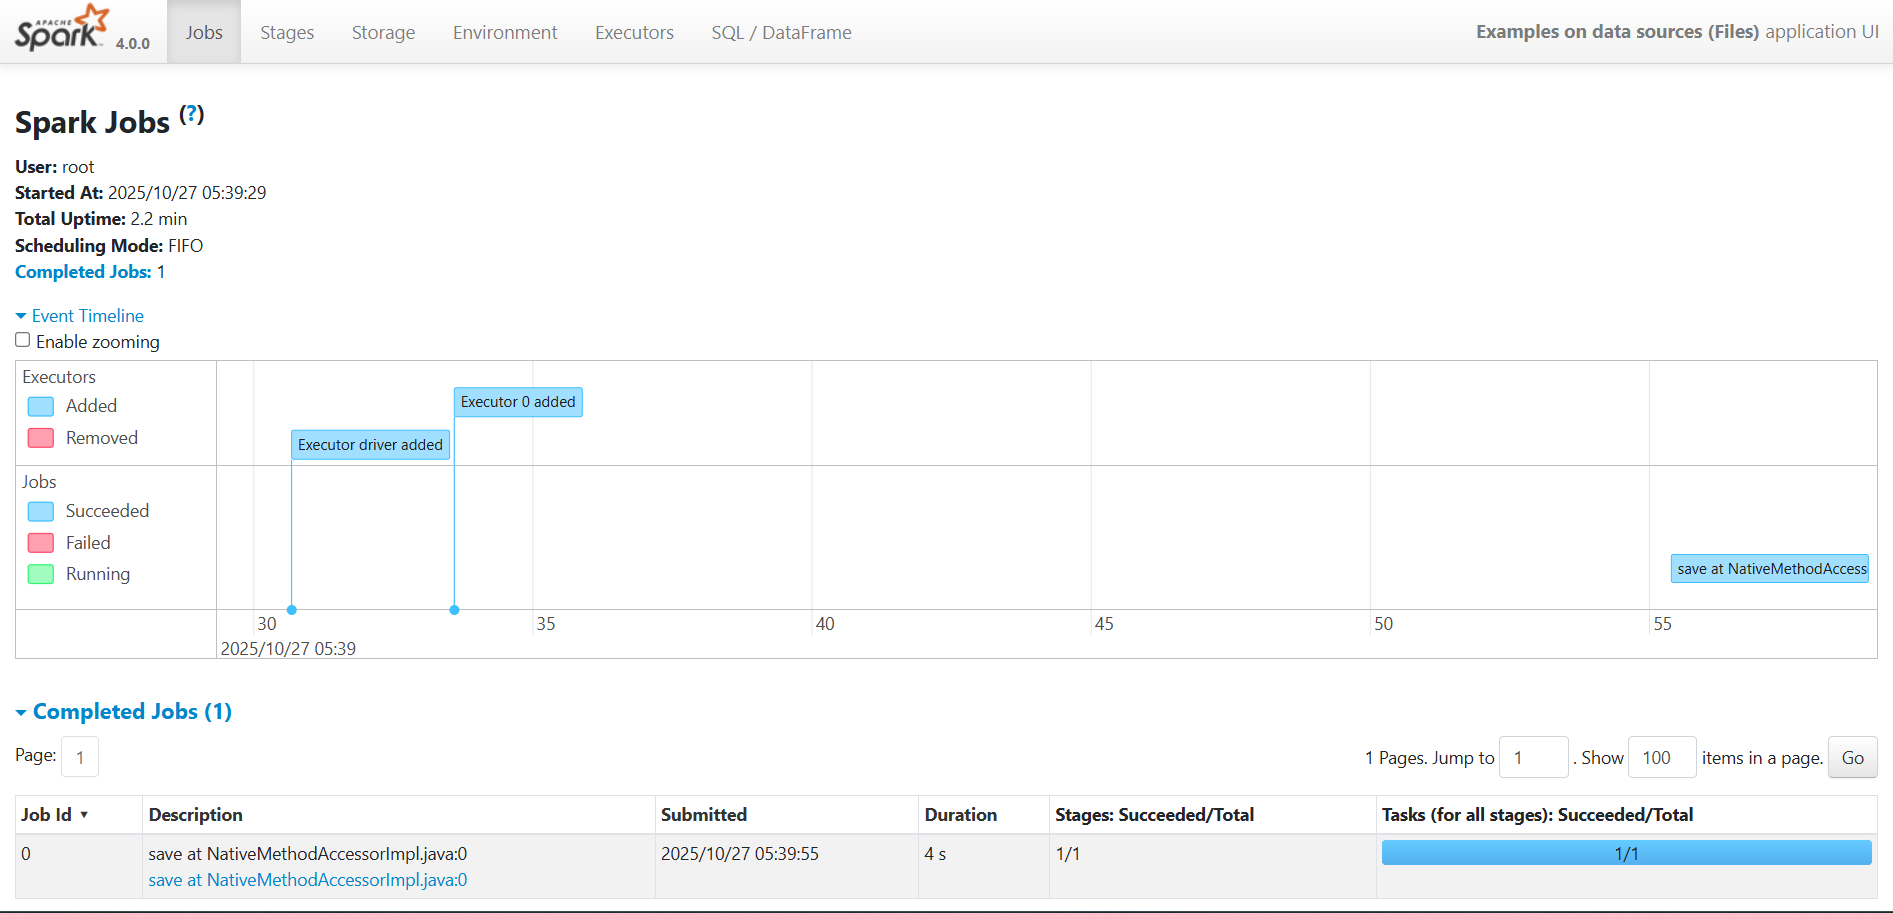

In [ ]:
sc.stop()

# DAG